In [1]:
import os
import torch
from d2l import torch as d2l
import matplotlib.pyplot as plt
from torch.utils import data

In [3]:
torch.cuda.device_count()

1

# 数据集预处理

In [2]:
#@save
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

#@save
def read_data_nmt():
    """载入“英语－法语”数据集"""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r',
             encoding='utf-8') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [3]:
# 预处理
def preprocess_nmt(text):
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '
    #用空格代替不间断空格（non-breaking space）\xa0 是不间断空白符 
    #使用小写字母替换大写字母
    text = text.replace('\u202f',' ').replace('\xa0',' ').lower()
    #在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char,text[i-1]) 
          else char for i, char in enumerate(text)]
    #print(out[:10])
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [4]:
# 词元化
def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据数据集"""
    #对前num_examples个文本序列对进行词元
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

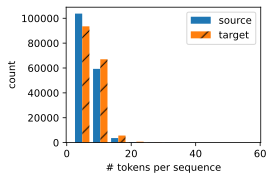

In [5]:
#@save
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """绘制列表长度对的直方图"""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', source, target);

In [30]:
# 词表
src_vocab = d2l.Vocab(source, min_freq=2, reserved_tokens=['<pad>','<bos>','<eos>'])
print(len(src_vocab))
print(src_vocab.token_freqs[:10])
print(list(src_vocab.token_to_idx.items())[:10])

10012
[('.', 139392), ('i', 45611), ('you', 43192), ('to', 36718), ('the', 33263), ('?', 27619), ('a', 23973), ('is', 16829), ('tom', 13990), ('that', 12651)]
[('<unk>', 0), ('<pad>', 1), ('<bos>', 2), ('<eos>', 3), ('.', 4), ('i', 5), ('you', 6), ('to', 7), ('the', 8), ('?', 9)]


In [7]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列,保证所有文本序列具有相同长度"""
    if len(line) > num_steps:
        return line[:num_steps] #截断
    return line + [padding_token]*(num_steps - len(line)) #填充

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [8]:
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines] #将词元转化为数字索引
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
    l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

In [9]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq = 2,
                         reserved_tokens=['<pad>','<bos>','<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                         reserved_tokens=['<pad>','<bos>','<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    dataset = data.TensorDataset(*data_arrays)
    data_iter = data.DataLoader(dataset, batch_size, shuffle=True)
    return data_iter, src_vocab, tgt_vocab

In [10]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2,
                                                num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break

X: tensor([[  7, 102,   4,   3,   1,   1,   1,   1],
        [ 26,  32,   5,   3,   1,   1,   1,   1]], dtype=torch.int32)
X的有效长度: tensor([4, 4])
Y: tensor([[  6,   7, 161,   4,   3,   1,   1,   1],
        [110,  32,  68,   5,   3,   1,   1,   1]], dtype=torch.int32)
Y的有效长度: tensor([5, 5])


# 编码器解码器
+ 可以将长度可变的序列作为输入和输出，因此适用于机器翻译等序列转换问题

In [11]:
from torch import nn

# -------------------encoder
# 编码器将长度可变的序列作为输入，并将其转换为具有固定形状的编码状态
class Encoder(nn.Module):
    """编码器-解码器架构的基本编码器接口"""
    def __init__(self, **kwargs):## **kwargs传递字典(按关键字传递数据)
        super(Encoder, self).__init__(**kwargs)
        
    def forward(self, X, *args):
        raise NotImplementedError
        

In [12]:
# -------------------decoder
# 解码器将具有固定形状的编码状态映射为长度可变的序列
class Decoder(nn.Module):
    """编码器-解码器架构的基本解码器接口"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        
    def init_state(self, enc_outputs, *args):
        raise NotImplementedError
    
    def forward(self,X, state):
        raise NotImplementedError

In [13]:
#----------------- 合并 encoder, decoder
class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

# Seq2Seq
+ 将使用两个循环神经网络的编码器和解码器， 并将其应用于序列到序列
1. 特定的\<bos\>表示序列开始词元，它是解码器的输入序列的第一个词元
2.  使用循环神经网络编码器最终的隐状态来初始化解码器的隐状态

In [14]:
class Seq2SeqEncoder(Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder,self).__init__(**kwargs)
        #嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                         dropout = dropout)
    
    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size, num_step, embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1,0,2)
        # 如果未提及初始状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

In [15]:
encoder = Seq2SeqEncoder(vocab_size=10,embed_size=8,
                        num_hiddens = 16, num_layers=2)
encoder.eval()
X = torch.zeros((4,7),dtype=torch.long)#先做了one_hot编码，然后词嵌入
output, state = encoder(X)
output.shape, state.shape

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

In [17]:
class Seq2SeqDecoder(Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 将decoder的输入与encoder的最后时刻隐藏状态（上下文变量）拼接
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens,num_layers,
                         dropout = dropout)
        # 定义输出层，用来预测下一个时间步的token
        self.dense = nn.Linear(num_hiddens, vocab_size)
    
    def init_state(self, enc_outputs, *args):
        # enc_outputs具有两个输出，分别为output, state
        return enc_outputs[1]
    
    def forward(self, X, state):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0],1,1) #取最后一个隐藏层状态
        X_and_context = torch.cat((X,context),2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1,0,2) 
        #输出为(batch_size, num_steps, vocab_size)
        #state形状为(num_layers, batch_size,num_hiddens)
        return output, state

In [18]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X,state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [40]:
#-----------------------损失函数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen),dtype = torch.float32,
                       device = X.device)[None,:] >= valid_len[:,None]
    X[mask] = value
#     mask = torch.arange((maxlen),dtype = torch.float32)[None,:] < valid_len[:,None]
#     X[~mask] = value
    return X

X = torch.tensor([[1,2,3],[4,5,6]])
valid_len = torch.tensor([1,2])
sequence_mask(X, valid_len)

tensor([[1, 0, 0],
        [4, 5, 0]])

In [29]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

In [32]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss,self).forward(
            pred.permute(0,2,1), label) #样本数保持一样，即batch_size,vocab_size,num_steps
        weighted_loss = (unweighted_loss * weights).mean(dim=1)#一个batch_size的平均损失
        return weighted_loss

In [33]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

In [37]:
##### 训练
def train_seq2seq(net, data_iter, lr, num_epochs, tqt_vocab,device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2) # 训练损失总和，词元数量
        
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']]*Y.shape[0],
                              device = device).reshape(-1,1)
            # 特定的序列开始词元（“<bos>”）和 原始的输出序列（不包括序列结束词元“<eos>”） 拼接在一起作为解码器的输入
            # 因为来自上一个时间步的预测得到的词元作为解码器的当前输入。
            dec_input = torch.cat([bos, Y[:,:-1]],1) #强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward() # 损失函数的标量进行“反向传播”
            d2l.grad_clipping(net, 1) #梯度裁剪，放置
            
            num_tokens = Y_valid_len.sum()#有效的token数
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
            
        if (epoch+1) % 10 == 0:
            animator.add(epoch+1, (metric[0] / metric[1],))
    #  token上的平均损失， 每秒处理多少个tokens
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

loss 0.020, 10478.1 tokens/sec on cuda


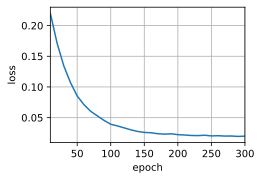

In [42]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300,torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [46]:
##   预测
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)],device = device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
    torch.tensor(src_tokens, dtype=torch.long, device=device),dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)#enc_valid_len在此处不需要，下面同理
    dec_state = net.decoder.init_state(enc_outputs,enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
                            [tgt_vocab['<bos>']] , dtype=torch.long, device = device),dim=0)
    output_seq, attention_weight_seq = [],[]
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)),attention_weight_seq
    

In [51]:
##   bleu
import math
import collections
def bleu(pred_seq, label_seq, k):
    '''计算bleu'''
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [52]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va essaye maintenant ., bleu 0.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est est chance est chance chance chance suis-je suis-je, bleu 0.258
i'm home . => je suis ici ., bleu 0.512
